Let's read in every Nth frame from a video file and perform inference on it using VGG16 pre-trained on ImageNet

In [19]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
import skvideo.io
from skimage.transform import resize
import skimage.io as io

In [13]:
model = VGG16()
#print(model.summary())

In [14]:
infile = './data/llama.mp4'
videodata = skvideo.io.vread(infile)
N_frames, rows, cols, channels = videodata.shape

The image must be 224x224 pixels in order to input to the model, but our image is not square. Solution: Create a blank (all-zeros) image, resize the width of our image to 224, and the resize the height by the same factor used to resize the width. Then place this into the blank, square one. There will be black bars at the top and bottom of the square input image because our frame width is greater than its height, but this will not affect our classifier. The few lines below will help us resize the frames in the main loop.

In [15]:
input_rows, input_cols = (224, 224)
Img = np.zeros((input_rows, input_cols, channels), np.uint8)
horz_scaling = input_cols/cols
rz_rows = int(rows * horz_scaling)
rz_cols = input_cols
nb_blank_rows = input_rows - rz_rows
blank_height = nb_blank_rows // 2

Below is the main loop through the video frames. Many videos are recorded at 24, 30, or 60 FPS (frames-per-second) and, depending on our implementation and on our hardware, performing inference on a frame will probably take longer than even the slowest of these rates. Besides, unless you have some object moving really fast, there will be little motion between frames and so it would be useless to classify each one. In the loop below I send only every 20th image to the classifier.

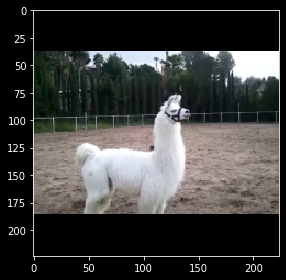

frame: 0 | prediction: llama (99.95%)


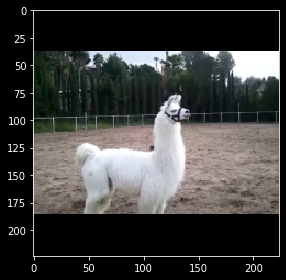

frame: 20 | prediction: llama (99.95%)


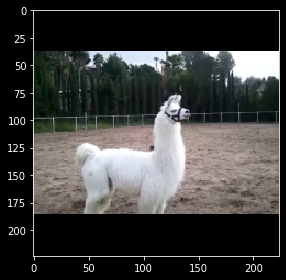

frame: 40 | prediction: llama (99.95%)


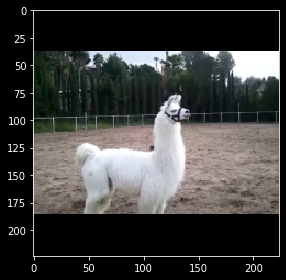

frame: 60 | prediction: llama (99.95%)


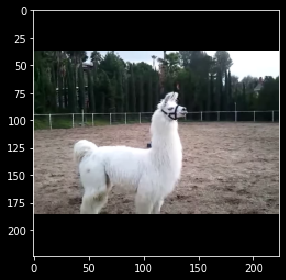

frame: 80 | prediction: llama (99.92%)


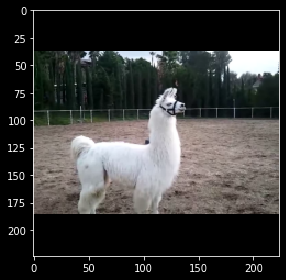

frame: 100 | prediction: llama (99.97%)


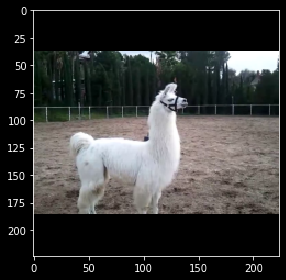

frame: 120 | prediction: llama (99.96%)


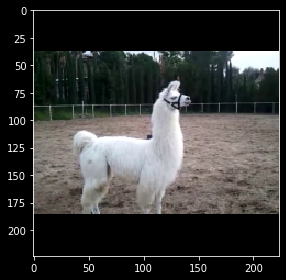

frame: 140 | prediction: llama (99.86%)


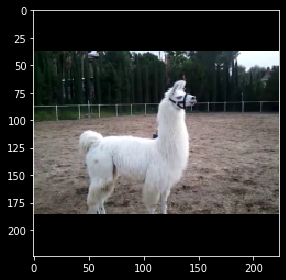

frame: 160 | prediction: llama (99.99%)


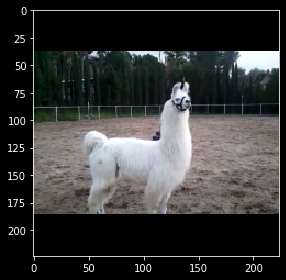

frame: 180 | prediction: llama (99.99%)


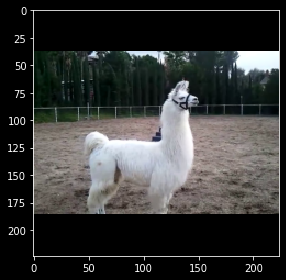

frame: 200 | prediction: llama (99.98%)


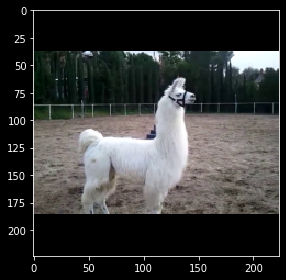

frame: 220 | prediction: llama (99.89%)


In [32]:
for iframe in range(N_frames):
    if iframe%20==0:
        imgnumb = str(iframe).zfill(4)
        
        # get the current frame
        Input = videodata[iframe,:,:,:] # shape = (480, 854, 3)
        
        # resize image to have width of 224
        Input = resize(Input, (rz_rows, rz_cols, channels))
        
        # resize resulted in an array of type float; convert to uint8
        maxval = np.max(Input)
        Input /= maxval
        Input *= 255
        Input = Input.astype(np.uint8)
        
        # insert this image into the 224x224 blank image
        Img[blank_height:blank_height+rz_rows, :] = Input
        
        # optional - display the frame
        io.imshow(Img)
        io.show()
        
        # inference
        Input = np.expand_dims(Img, axis=0)
        Input = preprocess_input(Input)
        pred = model.predict(Input)
        label = decode_predictions(pred)
        label = label[0][0] # the classification with the highest probability
        # print the result
        print(f'frame: {iframe} | prediction: {label[1]+" ("}{label[2]*100:0.2f}%)')